## Linear function: signature + fourier

Notation

`X_path`: a collection of path $\mathcal{X}=\{x^{(1)}, x^{(2)}, \dots, x^{(R)}\}\in \mathbb{R}^{R\times n}$ (assuming each sample $x^{(i)}\in \mathbb{R}^{1\times n}$ is a row vector)

In [125]:
import numpy as np
from torch.utils.data import Dataset
from fbm import FBM
import iisignature
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

In [126]:
def fbm_generator(sample_num, n, hurst):
    f = FBM(n=n-1, hurst=hurst)
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        data[i] = f.fbm()
    return data

def rand_sin_generator(sample_num, n, rand_num=20):
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        coef = np.random.randn(rand_num)*10
        data[i] = np.sum(np.sin(np.outer(coef, np.linspace(0, 1, n))), axis=0)
    return data

def sig_AT(path, s_depth, time=None):
    R, n = path.shape
    siglength = iisignature.siglength(2, s_depth)
    if time is None:
        time = np.linspace(0, 1, n)
    sig = np.zeros((R, siglength))
    for i in range(R):
        path_AT = np.vstack((time, path[i])).T
        sig[i] = iisignature.sig(path_AT, s_depth)
    return sig

def fft_aug(path, f_depth):
    coef = np.fft.rfft(path)[:, :f_depth]
    return np.concatenate((coef.real, coef.imag), axis=1)

def ifft_aug(coef_aug, n, f_depth):
    m, ns = coef_aug.shape
    coef = coef_aug[:, :ns//2] + coef_aug[:, ns//2:] * 1j
    coef_full = np.concatenate((coef, np.zeros((m, n//2-f_depth+1))), axis=1)
    return np.fft.irfft(coef_full)

In [138]:
class sig_Dataset(Dataset):
    def __init__(self, sample_num, n, f_depth, s_depth):
        self.sample_num = sample_num
        self.n = n
        self.f_depth = f_depth
        # self.path = fbm_generator(sample_num, n, hurst=0.95)
        self.path = rand_sin_generator(sample_num, n, rand_num=50)
        self.inputs = sig_AT(self.path, s_depth, time=np.linspace(0, 1, n))
        self.labels = fft_aug(self.path, f_depth)
        self.inputs_dim = self.inputs.shape[1]
        self.labels_dim = self.labels.shape[1]

    def __len__(self):
        return self.sample_num

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

    def reconstruct_path(self, idx=None):
        if idx is None:
            return ifft_aug(self.labels, self.n, self.f_depth)
        else:
            return ifft_aug(self.labels[idx].reshape(1, -1),
                            self.n, self.f_depth).flatten()

#### Initialise dataset

In [145]:
sample_num = 20
n = 100
f_depth = 5
s_depth = 1
data = sig_Dataset(sample_num=sample_num,
                        n=n,
                        f_depth=f_depth,
                        s_depth=s_depth)

#### FFT Visualisation

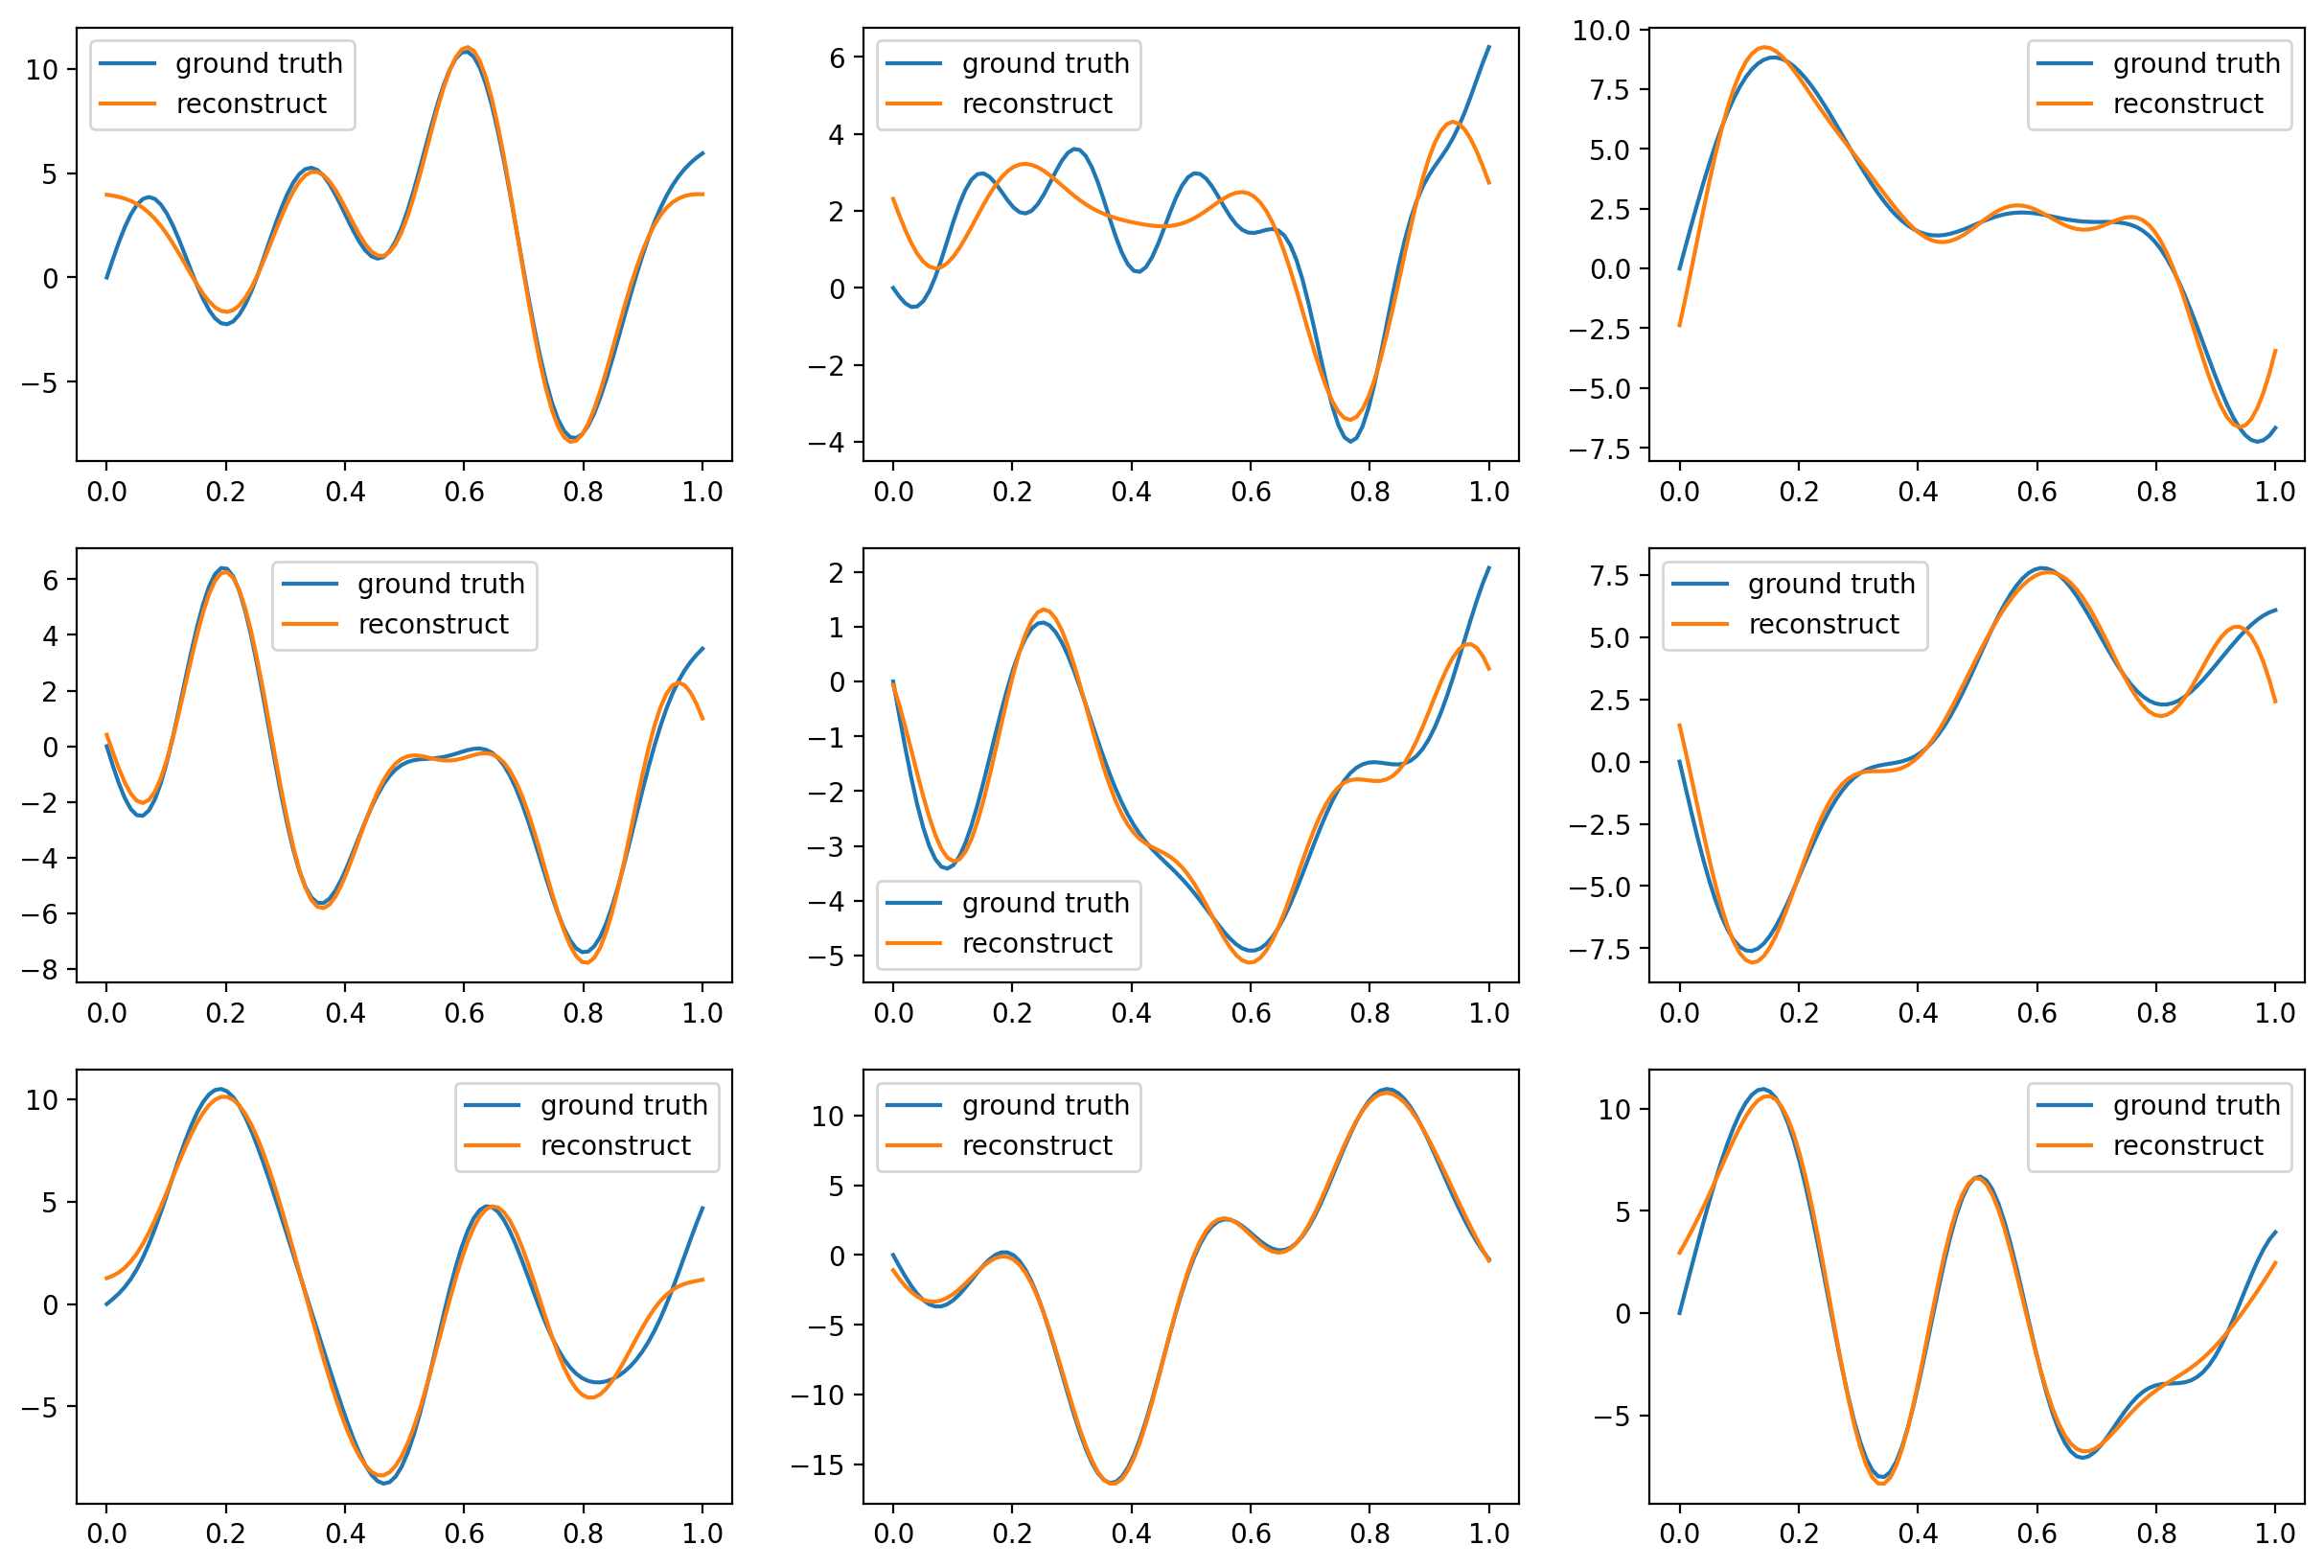

In [146]:
plt.figure(figsize=(15, 10), dpi=200)
for idx in range(9):
    example_path = data.path[idx]
    freq_path = data.reconstruct_path(idx=idx).flatten()
    plt.subplot(3, 3, idx+1)
    plt.plot(np.linspace(0, 1, n), example_path, label='ground truth')
    plt.plot(np.linspace(0, 1, n), freq_path, label='reconstruct')
    plt.legend()

#### Linear regression model

#### Compare different parameters

In [7]:
n_list = torch.tensor([10, 50, 100, 200])
s_depth_list = torch.tensor([2, 6, 10, 14])
f_depth_list = torch.tensor([2, 20, 40, 90])
error_mat = torch.zeros((len(n_list), len(s_depth_list), len(f_depth_list)))

for i in range(len(n_list)):
    for j in tqdm.tqdm(range(len(s_depth_list))):
        for k in range(len(f_depth_list)):
            data = sig_Dataset(sample_num=sample_num,
                                    n=n_list[i].item(),
                                    hurst=hurst,
                                    f_depth=f_depth_list[k].item(),
                                    s_depth=s_depth_list[j].item())
            test_data = sig_Dataset(sample_num=sample_num,
                                    n=n_list[i].item(),
                                    hurst=hurst,
                                    f_depth=f_depth_list[k].item(),
                                    s_depth=s_depth_list[j].item())
            error_mat[i, j, k] = test_data.mse(A=data.A)

100%|██████████| 4/4 [04:23<00:00, 65.77s/it]


In [13]:
n_idx = [f'n={n.item()}' for n in n_list]
s_depth_idx = [f's_depth={s_depth.item()}' for s_depth in s_depth_list]
f_depth_idx = [f'f_depth={f_depth.item()}' for f_depth in f_depth_list]
df_n_100 = pd.DataFrame(error_mat[2], columns=f_depth_idx, index=s_depth_idx)
df_s_10 = pd.DataFrame(error_mat[:, 2, :], columns=f_depth_idx, index=n_idx)
df_f_40 = pd.DataFrame(error_mat[:, :, 2], columns=s_depth_idx, index=n_idx)

In [14]:
df_n_100

,f_depth=2,f_depth=20,f_depth=40,f_depth=90
s_depth=2,0.140721,0.016989,0.008301,0.005735
s_depth=6,0.018592,0.015703,0.013250,0.008026
s_depth=10,0.088201,0.073509,0.015702,0.078727
s_depth=14,0.266436,0.726986,0.063882,0.049165


In [15]:
df_s_10

,f_depth=2,f_depth=20,f_depth=40,f_depth=90
n=10,0.006970,0.023272,0.007208,0.110608
n=50,0.007701,0.013150,0.460758,0.008712
n=100,0.088201,0.073509,0.015702,0.078727
n=200,0.219471,0.187768,0.062757,0.340740


In [16]:
df_f_40

,s_depth=2,s_depth=6,s_depth=10,s_depth=14
n=10,0.004948,0.004749,0.007208,0.007476
n=50,0.006622,0.054372,0.460758,0.062741
n=100,0.008301,0.013250,0.015702,0.063882
n=200,0.016792,0.032805,0.062757,0.146585


In [10]:
## Linear model implementation
# class LinearRegressionModel(torch.nn.Module):
#     def __init__(self, in_channel, out_channel):
#         super(LinearRegressionModel, self).__init__()
#         self.linear = torch.nn.Linear(in_channel, out_channel)
 
#     def forward(self, x):
#         y_pred = self.linear(x)
#         return y_pred

# model = LinearRegressionModel(in_channel=data.inputs_dim, out_channel=data.labels_dim)
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# for epoch in range(5000):
#     pred_y = model(data.inputs)
#     loss = criterion(pred_y, data.labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch%500==0:
#         print('epoch {}, loss {}'.format(epoch, loss.item()))

# with torch.no_grad():
#     example_sig, example_freq = data[4]
#     example_path = data.path[4]
#     freq_path = torch.fft.irfft(example_freq)
#     est_freq = model(example_sig).data
#     est_path = torch.fft.irfft(est_freq)